In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import cv2 as cv
import warnings
from tensorflow.keras import layers, models
from tensorflow.keras import backend as K
import itertools
import matplotlib.cm as cm
import skimage.transform as st
from enum import Enum
from sklearn.metrics import roc_curve, auc, classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage.filters import gaussian_filter
import gc

print(tf.__version__)
warnings.filterwarnings("ignore")

gpus = tf.config.list_physical_devices(device_type='GPU')
tf.config.set_visible_devices(devices=gpus[1], device_type='GPU')

2.4.0


In [2]:
gender_list = ['M', 'F']
age_range = ['0-20', '20-40', '40-60', '60-80', '80-']
bmi_interval = ['<18.5', '18.5-25', '25-30', '>30']

In [3]:
seed = 2021
os.environ['PYTHONHASHSEED']=str(seed)
tf.random.set_seed(seed)
np.random.seed(seed)

In [6]:
def get_data(data_split='test', test_type='NULL', target='NULL'):
    X_test = []
    y_test = []
    
    if (data_split == 'train'):
        filename = 'Data/mimic_train.tfrecords'
    elif(data_split == 'val'):
        filename = 'Data/mimic_val.tfrecords'
    else:
        filename = 'Data/mimic_test.tfrecords'
        
    raw_dataset = tf.data.TFRecordDataset(filename)
    for raw_record in raw_dataset:
        sub_y = []

        example = tf.train.Example()
        example.ParseFromString(raw_record.numpy())
                
        ethnicity = example.features.feature['race'].int64_list.value[0]
                        
        if (test_type == 'age'):
            age = example.features.feature['age'].int64_list.value[0]
                        
            if not (age == target):
                continue
        
        elif (test_type == 'gender'):
            gender = example.features.feature['gender'].int64_list.value[0]
            
            if not (gender == target):
                continue
        
        elif (test_type == 'bmi'):
            bmi_interval = example.features.feature['bmi'].int64_list.value[0]
            
            if not (bmi_interval == target):
                continue
            
        if (ethnicity == 0):
            label = tf.constant([1, 0, 0])
        elif (ethnicity == 1):
            label = tf.constant([0, 1, 0])
        elif (ethnicity == 4):
            label = tf.constant([0, 0, 1])
        else:
            continue

        nparr = np.fromstring(example.features.feature['jpg_bytes'].bytes_list.value[0], np.uint8)
        img_np = cv.imdecode(nparr, cv.IMREAD_GRAYSCALE)

        X_test.append(st.resize(img_np, (224, 224)))
        
        y_test.append(label)
                        
    return np.array(X_test), np.array(y_test)

In [9]:
INPUT_SHAPE = (224, 224, 1)
BATCH_SIZE = 128

init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

def define_model():
    
    input = tf.keras.layers.Input(shape=INPUT_SHAPE)
    
    x = tf.keras.layers.Conv2DTranspose(3, (3, 3), strides=1, padding='same', kernel_initializer=init, use_bias=False)(input)
    
    base_model = tf.keras.applications.densenet.DenseNet121(
            include_top=False, weights='imagenet', input_shape=(224, 224, 3), pooling='max')(x)
         
    pred_layer = tf.keras.layers.Dense(3, activation='sigmoid')(base_model)
 
    model = tf.keras.Model(inputs=input, outputs=pred_layer)    
  
    return model

In [6]:
model = define_model()

def scheduler(epoch, lr):
    if epoch % 2 == 0:
        return lr * tf.math.exp(-0.05)
    else:
        return lr

callback = [tf.keras.callbacks.LearningRateScheduler(scheduler)]

print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 1)]     0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 224, 224, 3)       27        
_________________________________________________________________
densenet121 (Functional)     (None, 1024)              7037504   
_________________________________________________________________
dense (Dense)                (None, 3)                 3075      
Total params: 7,040,606
Trainable params: 6,956,958
Non-trainable params: 83,648
_________________________________________________________________
None


In [7]:
X_train, y_train = get_data(data_split='train')
X_val, y_val = get_data(data_split='val')

In [10]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                 optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics='AUC')

model.fit(X_train, y_train, epochs=10, shuffle=True, callbacks=callback, validation_data=(X_val, y_val), batch_size=BATCH_SIZE)

Epoch 1/10
910/910 [==============================] - 8677s 6s/step - loss: 0.5255 - auc: 0.9158 - val_loss: 0.3654 - val_auc: 0.9540
Epoch 2/10
910/910 [==============================] - 344s 378ms/step - loss: 0.2228 - auc: 0.9726 - val_loss: 0.3234 - val_auc: 0.9316
Epoch 3/10
910/910 [==============================] - 345s 379ms/step - loss: 0.1724 - auc: 0.9826 - val_loss: 0.2761 - val_auc: 0.9730
Epoch 4/10
910/910 [==============================] - 344s 378ms/step - loss: 0.1414 - auc: 0.9886 - val_loss: 0.4663 - val_auc: 0.9311
Epoch 5/10
910/910 [==============================] - 345s 379ms/step - loss: 0.1218 - auc: 0.9908 - val_loss: 0.3284 - val_auc: 0.9620
Epoch 6/10
910/910 [==============================] - 344s 378ms/step - loss: 0.0965 - auc: 0.9929 - val_loss: 0.2531 - val_auc: 0.9783
Epoch 7/10
910/910 [==============================] - 344s 378ms/step - loss: 0.0799 - auc: 0.9947 - val_loss: 0.3213 - val_auc: 0.9726
Epoch 8/10
910/910 [==============================

In [11]:
model.save('saved_model/Dnet121')

INFO:tensorflow:Assets written to: saved_model/Dnet121/assets


In [8]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot
 
    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix
 
    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']
 
    title:        the text to display at the top of the matrix
 
    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues
 
    normalize:    If False, plot the raw numbers
                  If True, plot the proportions
 
    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph
 
    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
 
    """
 
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
 
    if cmap is None:
        cmap = plt.get_cmap('Blues')
 
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
 
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
 
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
 
 
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
 
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    
    plt.show()
    
def plot_roc(y_test, preds, title, label):
    fig = plt.figure(figsize=(8,6))

    for i in range(len(label)):
        fpr, tpr, _ = roc_curve(y_test[:, i], preds[:, i])
        roc_auc = auc(fpr, tpr)
        # plot the roc curve for the model
        plt.plot(fpr, tpr, linestyle='solid', label='{} AUC={:.3f}'.format(label[i], roc_auc))

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.plot([0,1], [0,1], color='orange', linestyle='--')
#     filename = title + '.svg'
#     plt.savefig(filename)
    plt.show()

In [9]:
def test(y_preds, y_test):
    
    n_bootstraps = 1000
    rng_seed = 2021  # control reproducibility
    bootstrapped_scores = []

    rng = np.random.RandomState(rng_seed)
    for i in range(n_bootstraps):
        # bootstrap by sampling with replacement on the prediction indices
        indices = rng.randint(0, len(y_preds), len(y_preds))
        if len(np.unique(y_test[indices])) < 2:
            # We need at least one positive and one negative sample for ROC AUC
            # to be defined: reject the sample
            continue

        score = roc_auc_score(y_test[indices], y_preds[indices])
        bootstrapped_scores.append(score)
        
    plt.hist(bootstrapped_scores, bins=100)
    plt.title('Histogram of the bootstrapped ROC AUC scores')
    plt.show()
    
    auc_score = np.array(bootstrapped_scores)
    
    mean_score = auc_score.mean()
    std_dev = auc_score.std()
    std_error = std_dev / np.math.sqrt(1)
    ci =  2.262 * std_error
    lower_bound = mean_score - ci
    upper_bound = mean_score + ci

    print("Sample auc mean: {:0.2f}". format(mean_score))
    print("Samole auc std: {:0.2f}".format(std_dev))
    print("Sample auc CI: {:0.2f}". format(ci))
    print("Confidence interval for the score: [{:0.2f} - {:0.2f}]".format(
        lower_bound, upper_bound))

In [10]:
Labels_race = ['WHITE', 'AFRICAN AMERICAN', 'ASIA']

def plot(y_preds, y_test):

    plot_roc(y_test, y_preds, 'ROC', Labels_race)

    cm_race = [0 for i in range(len(Labels_race))]
    for i in range(len(Labels_race)):
        cm_race[i] = [0 for j in range(len(Labels_race))]

    preds = tf.one_hot(tf.argmax(y_preds, axis=1), len(Labels_race))
    for i in range(len(y_test)):
        cm_race[np.argmax(preds[i])][np.argmax(y_test[i])] += 1

    plot_confusion_matrix(np.array(cm_race).transpose(), 
                          normalize = False,
                          target_names = Labels_race,
                          title = 'CM')

(58615, 224, 224)


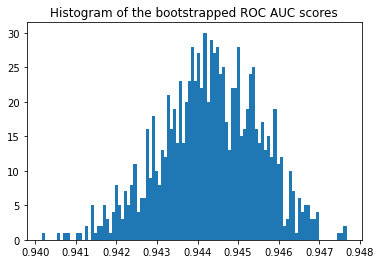

Sample auc mean: 0.94
Samole auc std: 0.00
Sample auc CI: 0.00
Confidence interval for the score: [0.94 - 0.95]


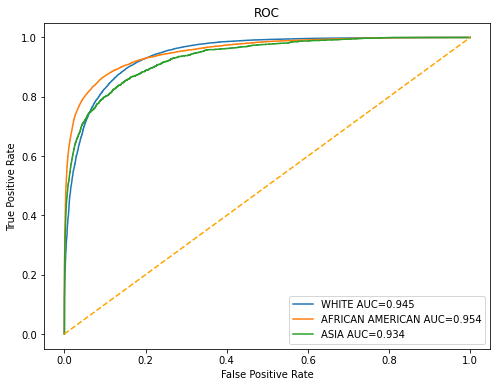

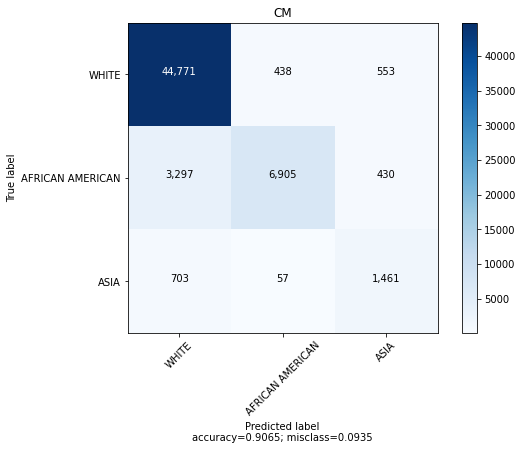

In [8]:
model = tf.keras.models.load_model('saved_model/Dnet121')

X_test, y_test = get_data()

print(X_test.shape)
y_preds = model.predict(X_test, batch_size=4)
test(y_preds, y_test)
plot(y_preds, y_test)

## AUC of different BMI category

BMI interval: <18.5   (387, 224, 224)


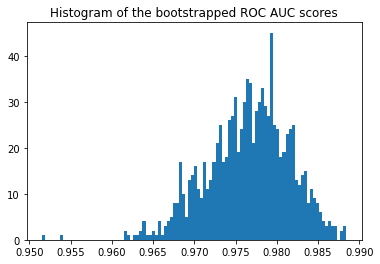

Sample auc mean: 0.98
Samole auc std: 0.00
Sample auc CI: 0.01
Confidence interval for the score: [0.97 - 0.99]


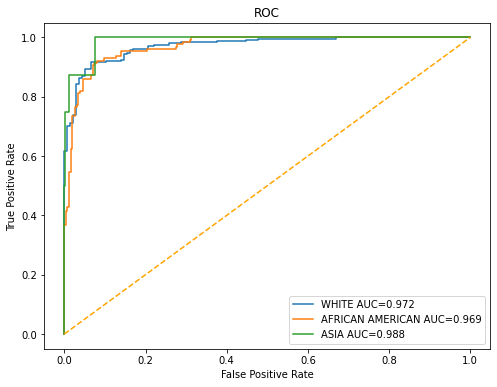

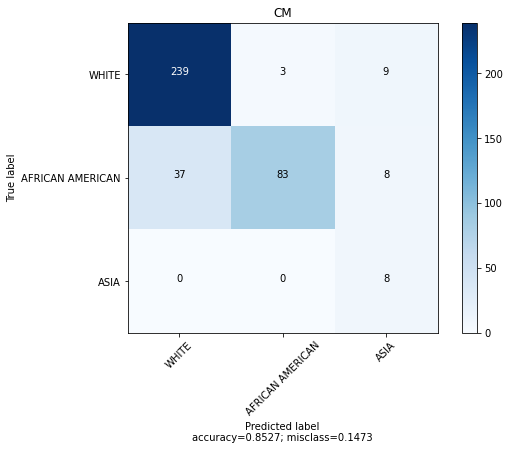

BMI interval: 18.5-25   (2968, 224, 224)


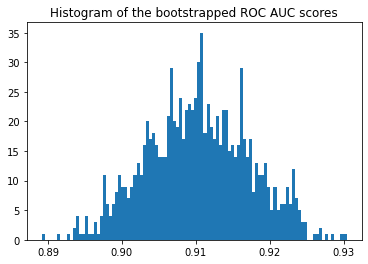

Sample auc mean: 0.91
Samole auc std: 0.01
Sample auc CI: 0.02
Confidence interval for the score: [0.89 - 0.93]


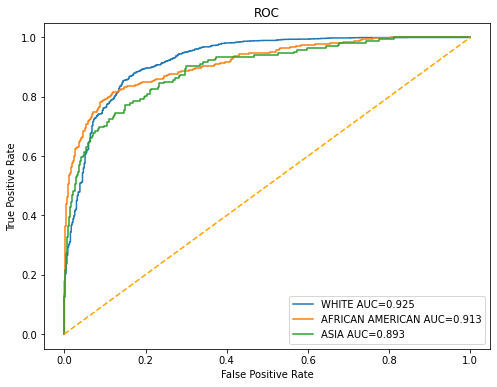

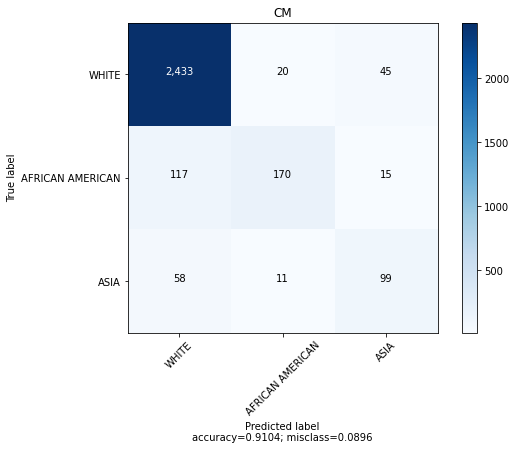

BMI interval: 25-30   (3192, 224, 224)


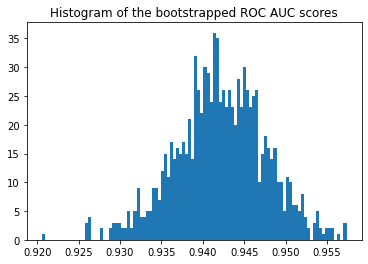

Sample auc mean: 0.94
Samole auc std: 0.01
Sample auc CI: 0.01
Confidence interval for the score: [0.93 - 0.95]


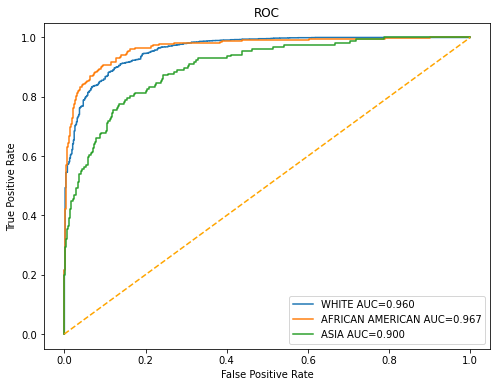

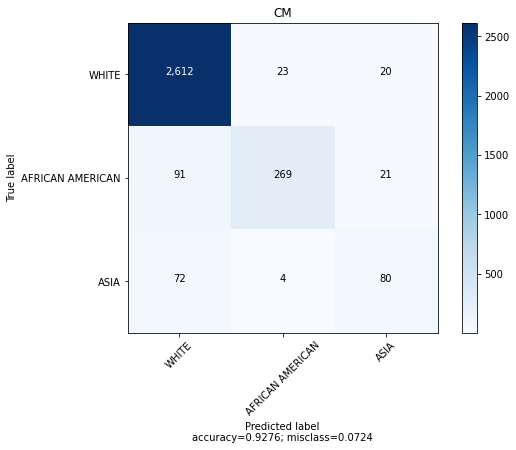

BMI interval: >30   (3490, 224, 224)


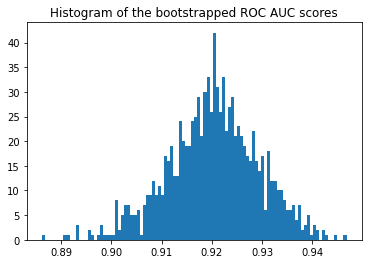

Sample auc mean: 0.92
Samole auc std: 0.01
Sample auc CI: 0.02
Confidence interval for the score: [0.90 - 0.94]


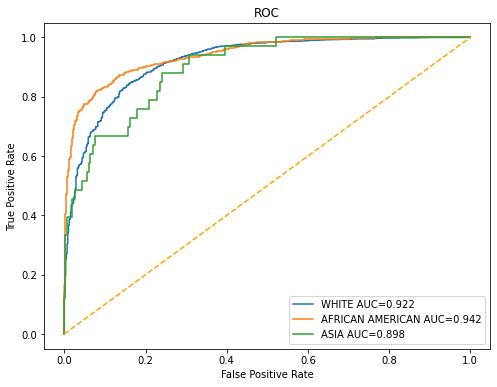

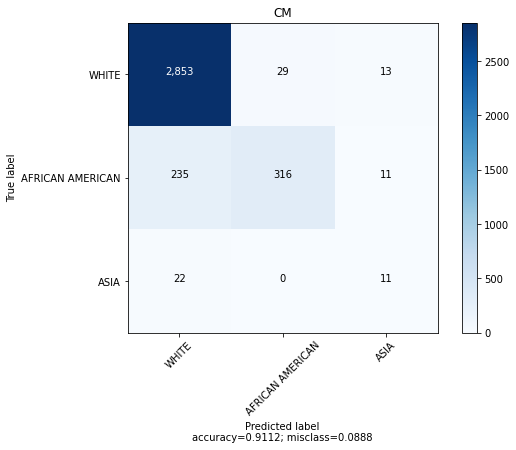

In [16]:
# bmi

for i in range(4):
    X_test, y_test = get_data(test_type='bmi', target=i)

    print('BMI interval:', bmi_interval[i], ' ', X_test.shape)
    y_preds = model.predict(X_test)
    test(y_preds, y_test)
    plot(y_preds, y_test)

Age interval: 0-20   (236, 224, 224)


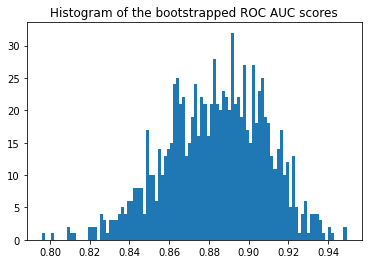

Sample auc mean: 0.88
Samole auc std: 0.03
Sample auc CI: 0.06
Confidence interval for the score: [0.83 - 0.94]


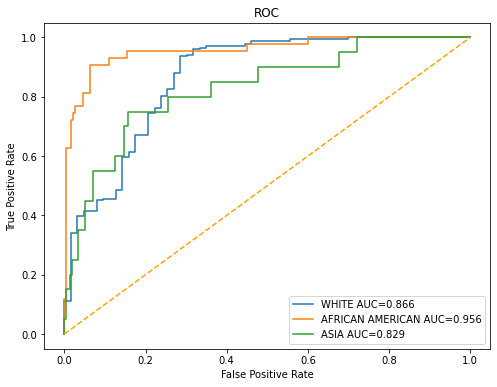

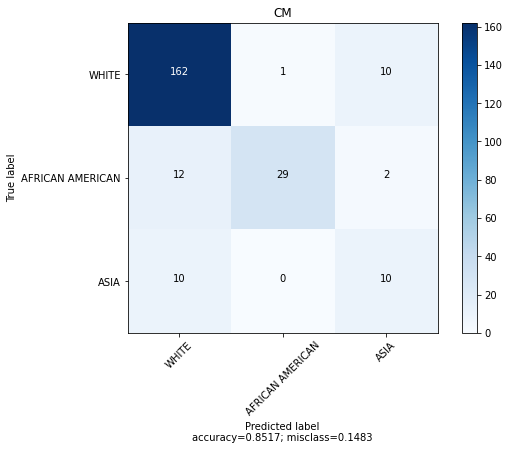

Age interval: 20-40   (6157, 224, 224)


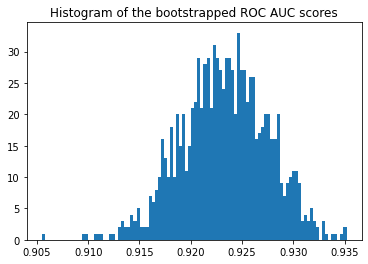

Sample auc mean: 0.92
Samole auc std: 0.00
Sample auc CI: 0.01
Confidence interval for the score: [0.91 - 0.93]


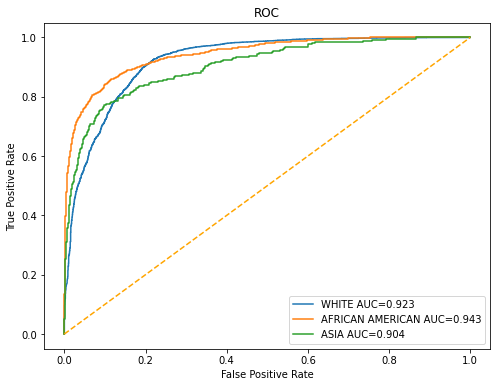

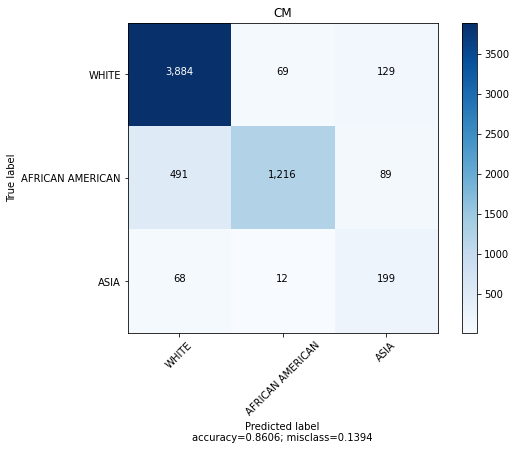

Age interval: 40-60   (17470, 224, 224)


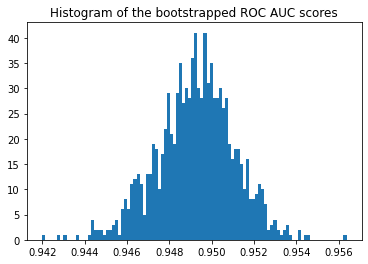

Sample auc mean: 0.95
Samole auc std: 0.00
Sample auc CI: 0.00
Confidence interval for the score: [0.95 - 0.95]


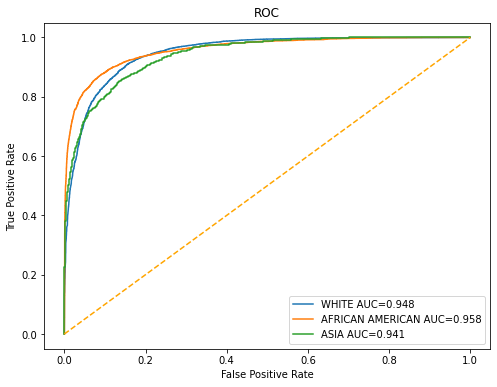

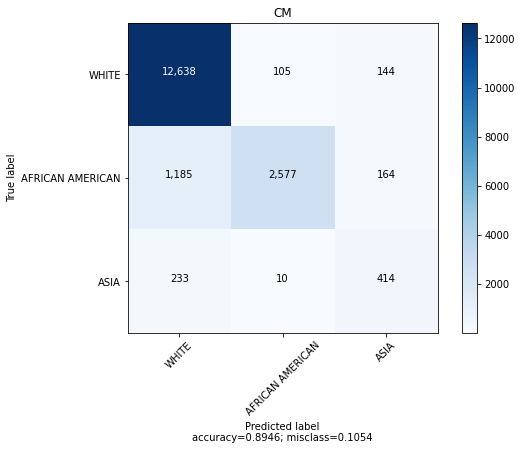

Age interval: 60-80   (25180, 224, 224)


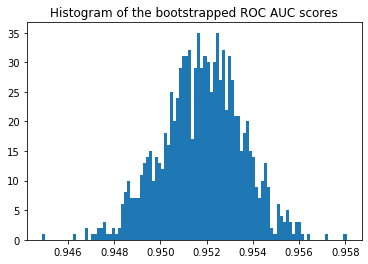

Sample auc mean: 0.95
Samole auc std: 0.00
Sample auc CI: 0.00
Confidence interval for the score: [0.95 - 0.96]


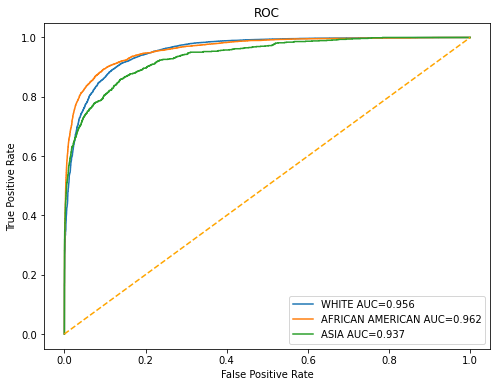

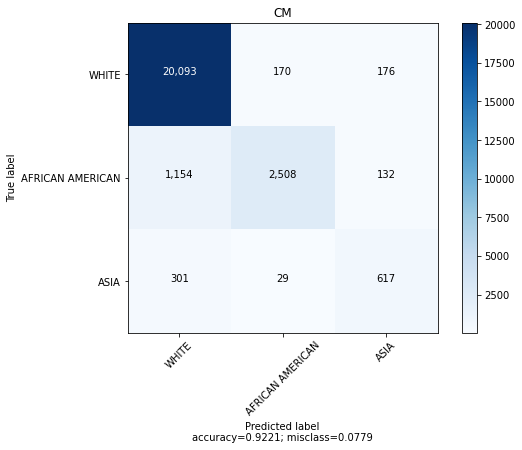

Age interval: 80-   (9572, 224, 224)


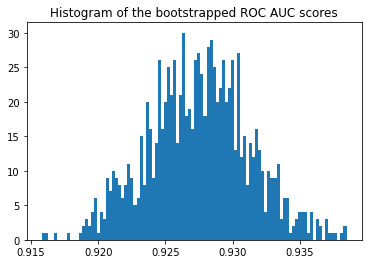

Sample auc mean: 0.93
Samole auc std: 0.00
Sample auc CI: 0.01
Confidence interval for the score: [0.92 - 0.94]


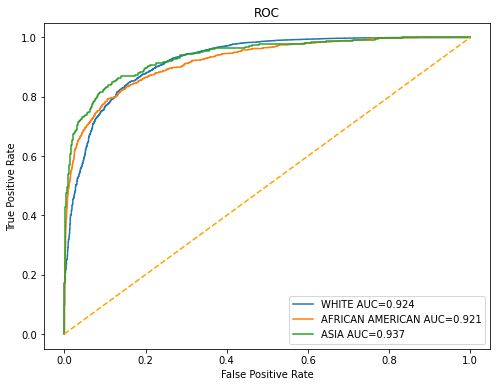

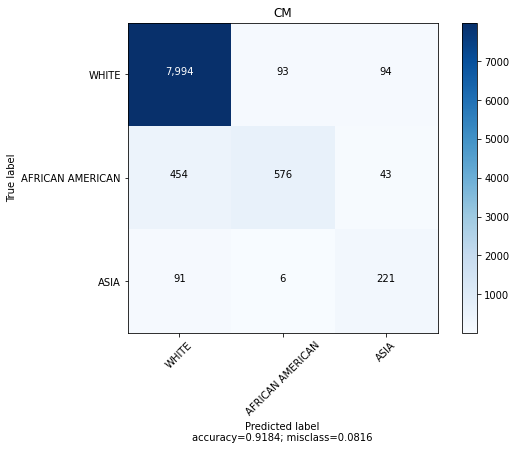

In [11]:
# age

for i in range(5):
    X_test, y_test = get_data(test_type='age', target=i)

    print('Age interval:', age_range[i], ' ', X_test.shape)
    y_preds = model.predict(X_test)
    test(y_preds, y_test)
    plot(y_preds, y_test)

Gender: M   (30704, 224, 224)


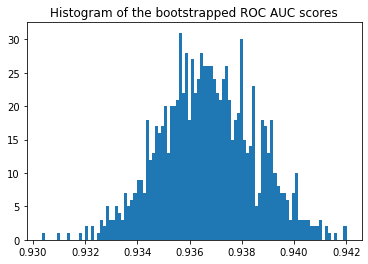

Sample auc mean: 0.94
Samole auc std: 0.00
Sample auc CI: 0.00
Confidence interval for the score: [0.93 - 0.94]


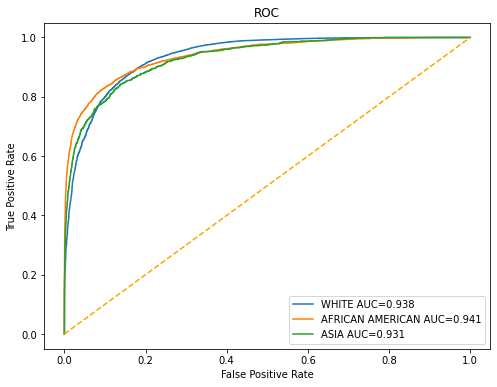

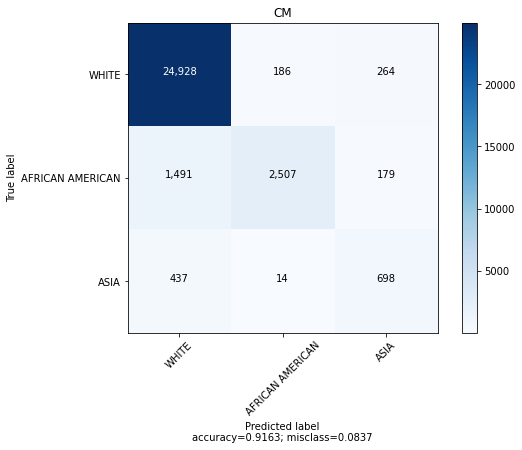

Gender: F   (27911, 224, 224)


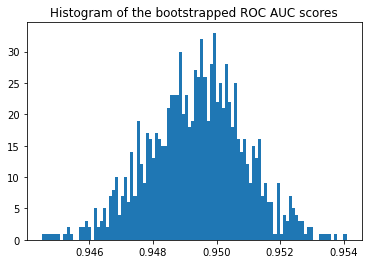

Sample auc mean: 0.95
Samole auc std: 0.00
Sample auc CI: 0.00
Confidence interval for the score: [0.95 - 0.95]


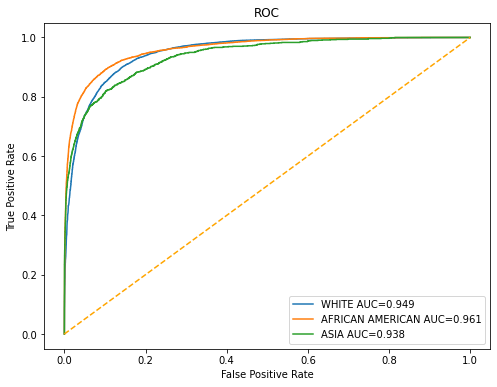

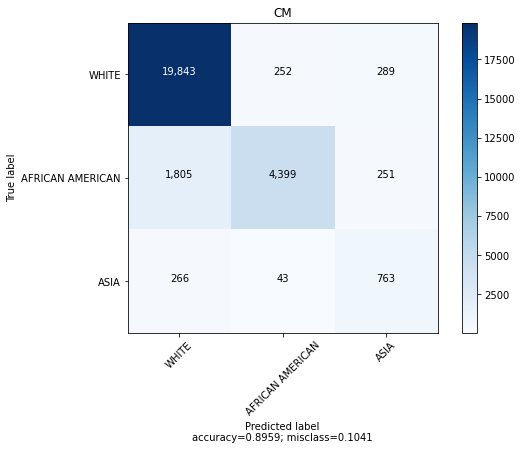

In [12]:
# gender

for i in range(2):
    X_test, y_test = get_data(test_type='gender', target=i)

    print('Gender:', gender_list[i], ' ', X_test.shape)
    y_preds = model.predict(X_test)
    test(y_preds, y_test)
    plot(y_preds, y_test)

## Noisy and Blurred

In [13]:
INPUT_SHAPE = (224, 224, 1)

def noisy(noise_type, image, sig):
    _, row, col, ch= image.shape
    if (noise_type == 0):
        mean = 0
        var = 0.1
        sigma = var**sig
        gauss = np.random.normal(mean, sigma,(row,col,ch))
        gauss = gauss.reshape(row,col,ch)
        noisy = image + gauss
        return noisy
    elif (noise_type == 1):
        blurred = gaussian_filter(np.float32(image), sigma=sig)
        return blurred

(58615, 224, 224)


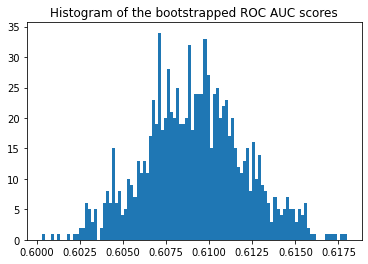

Sample auc mean: 0.61
Samole auc std: 0.00
Sample auc CI: 0.01
Confidence interval for the score: [0.60 - 0.62]


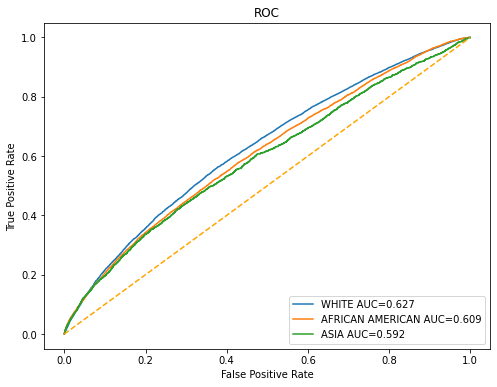

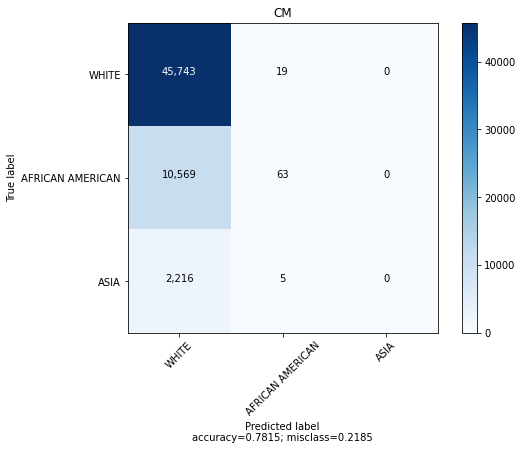

In [17]:
# noisy
# X_test, y_test = get_data()

print(X_test.shape)
y_preds = model.predict(noisy(0, X_test.reshape(len(X_test), 224, 224, 1), 1))
test(y_preds, y_test)
plot(y_preds, y_test)

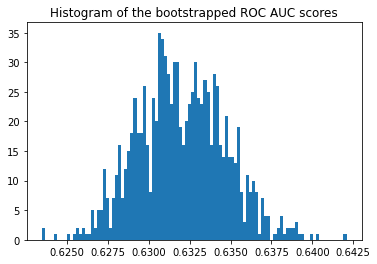

Sample auc mean: 0.63
Samole auc std: 0.00
Sample auc CI: 0.01
Confidence interval for the score: [0.63 - 0.64]


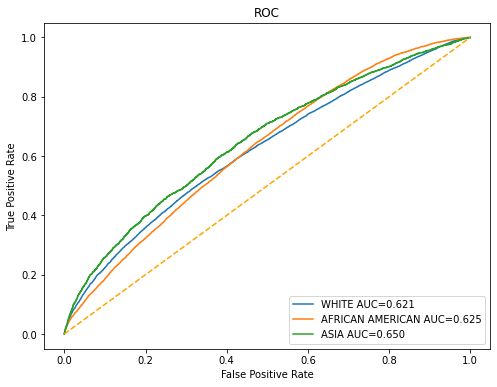

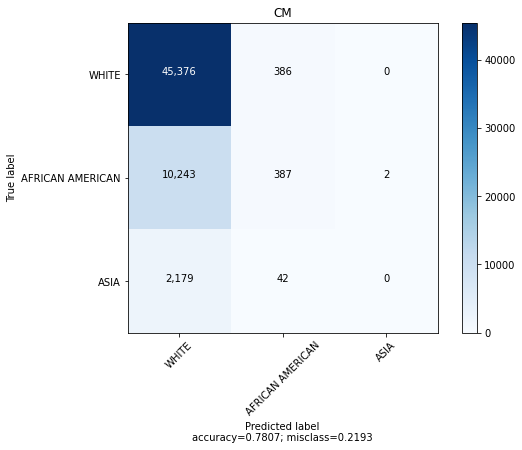

In [18]:
# blurred

y_preds = model.predict(noisy(1, X_test.reshape(len(X_test), 224, 224, 1), 2))
test(y_preds, y_test)
plot(y_preds, y_test)

## Masked CXRs

In [45]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 1)]     0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 224, 224, 3)       27        
_________________________________________________________________
densenet121 (Functional)     (None, 1024)              7037504   
_________________________________________________________________
dense (Dense)                (None, 3)                 3075      
Total params: 7,040,606
Trainable params: 6,956,958
Non-trainable params: 83,648
_________________________________________________________________


In [48]:
# model = tf.keras.models.load_model('saved_model/Dnet_race_split_256')

last_conv_layer_name = 'relu'
classifier_layer_names = ['max_pool']

def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    densenet121 = model.get_layer('densenet121')
    convtranspose = model.get_layer('conv2d_transpose')
    input_layer = model.get_layer('input_1')
    last_conv_layer = densenet121.get_layer(last_conv_layer_name)
    last_conv_layer_model = tf.keras.Sequential()
    last_conv_layer_model.add(input_layer)
    last_conv_layer_model.add(convtranspose)
    last_conv_layer_model.add(tf.keras.Model(densenet121.inputs, last_conv_layer.output))

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = densenet121.get_layer(layer_name)(x)
    x = model.get_layer('dense')(x)
    classifier_model = tf.keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    
    return heatmap

In [21]:
def show_heatmap(img_array, last_conv_layer_name, classifier_layer_names):

    heatmap = make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
    )

    # Display heatmap
    # plt.matshow(heatmap)
    # plt.show()

    heatmap = np.uint8(255 * heatmap)

    jet = cm.get_cmap("jet")

    # We use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # We create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((256, 256))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    return jet_heatmap

In [52]:
def get_mask_img(img, threshold):
    
    jet_heatmap = show_heatmap(np.reshape(img, (1, 224, 224, 1)), last_conv_layer_name, classifier_layer_names)
    
    hottest_areas = np.ma.MaskedArray(jet_heatmap[:, :, 2], jet_heatmap[:, : ,2] < threshold)

    where = np.array(np.where(hottest_areas.mask))
    
    img_ = np.repeat(img, 3, -1)
    
    try:
        x1, y1 = np.amin(where, axis=1)
        x2, y2 = np.amax(where, axis=1)

        img_rec = cv.rectangle(img_, (y1, x1), (y2, x2), (0, 0, 0), -1)
        
    except:
        img_rec = img_


    return img_rec[:, :, 2]

In [ ]:
X_masked_img = [] 
for i in range(len(X_test)):
    X_masked_img.append(get_mask_img(X_test[i].reshape(224, 224, 1), 0.1))

In [ ]:
y_preds = model.predict(np.reshape(X_masked_img, (len(X_masked_img), 224, 224, 1)))
test(y_preds, y_test)
plot(y_preds, y_test)

## Show CXRs

In [ ]:
for i in range(5):
    fig, axs = plt.subplots(1, 4)
    fig.set_size_inches(18.5, 10.5)
    
    axs[0].set_title('Normal CXR')
    axs[0].imshow(X_test[i], cmap='gray')
    axs[1].set_title('Noisy CXR')
    axs[1].imshow(noisy(0, X_test[i], 1), cmap='gray')
    axs[2].set_title('Blurred CXR')
    axs[2].imshow(noisy(1, X_test[i], 2), cmap='gray')
    axs[3].set_title('Masked CXR')
    axs[3].imshow(X_masked_img[i], cmap='gray')
    plt.show()

In [ ]:
from sklearn.metrics import auc, accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
import seaborn as sns

In [ ]:
labels = ['WHITE', 'BLACK', 'ASIA']
modified_y_test = []
X_test, y_test = get_data(train=False)

result = model.predict(X_test)
labels = np.argmax(result, axis=1)

for i in range(len(y_test)):
    if (np.array_equal([1, 0, 0], y_test[i])):
        modified_y_test.append(0)
    if (np.array_equal([0, 1, 0], y_test[i])):
        modified_y_test.append(1)
    if (np.array_equal([0, 0, 1], y_test[i])):
        modified_y_test.append(2)

print (classification_report(modified_y_test, labels))
class_matrix = confusion_matrix(modified_y_test, labels)
sns.heatmap(class_matrix, annot=True, fmt='d', cmap='Blues')